In [1]:
#!pip install pyPPG==1.0.41


In [2]:
from pyPPG import PPG, Fiducials, Biomarkers
from pyPPG.datahandling import load_data, plot_fiducials, save_data
import pyPPG.preproc as PP
import pyPPG.fiducials as FP
import pyPPG.biomarkers as BM
import pyPPG.ppg_sqi as SQI

In [3]:
import numpy as np
import sys
import json
import pandas as pd

Setup input parameters:
_______________________
_The following input parameters are inputs to the `pyPPG.example` module (see the [documentation](https://pyppg.readthedocs.io/en/latest/pyPPG.html#module-pyPPG.example) for further details)._

In [4]:
data_path = "Sample_PPG_MAT_125Hz.mat" # the path of the file containing the PPG signal to be analysed
start_sig = 0 # the first sample of the signal to be analysed
end_sig = -1 # the last sample of the signal to be analysed (here a value of '-1' indicates the last sample)
savingfolder = 'temp_dir'
savingformat = 'csv'

Load a raw PPG signal:
__________________________

In [5]:
# Load the raw PPG signal
signal = load_data(data_path=data_path, start_sig=start_sig, end_sig=end_sig, use_tk=False)
signal.v = signal.v [0:20*signal.fs] # 20 second long signal to be analysed

Plot the raw PPG signal:

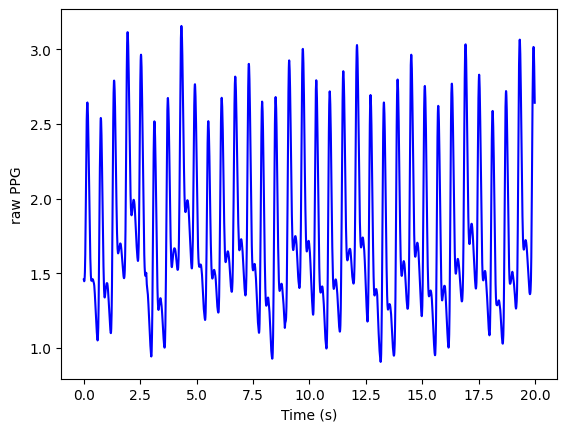

In [6]:
# import plotting package
from matplotlib import pyplot as plt

# setup figure
fig, ax = plt.subplots()

# create time vector
t = np.arange(0, len(signal.v))/signal.fs

# plot raw PPG signal
ax.plot(t, signal.v, color = 'blue')
ax.set(xlabel = 'Time (s)', ylabel = 'raw PPG')

# show plot
plt.show()

## PPG signal processing

In [7]:
signal.filtering = True # whether or not to filter the PPG signal
signal.fL=0.5000001 # Lower cutoff frequency (Hz)
signal.fH=12 # Upper cutoff frequency (Hz)
signal.order=4 # Filter order
signal.sm_wins={'ppg':50,'vpg':10,'apg':10,'jpg':10} # smoothing windows in millisecond for the PPG, PPG', PPG", and PPG'"
prep = PP.Preprocess(fL=signal.fL, fH=signal.fH, order=signal.order, sm_wins=signal.sm_wins)
signal.ppg, signal.vpg, signal.apg, signal.jpg = prep.get_signals(s=signal)

Plot the derived signals

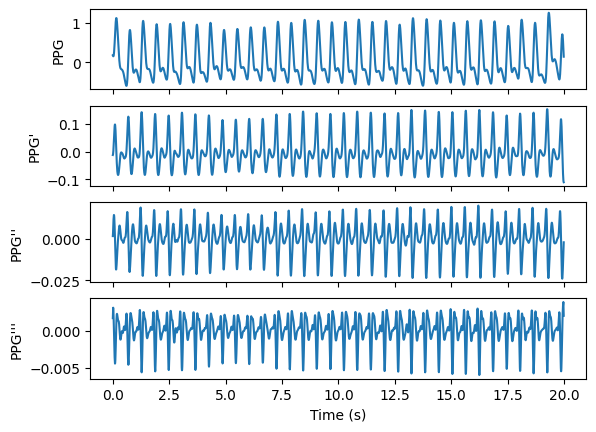

In [8]:
# setup figure
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 1, sharex = True, sharey = False)

# create time vector
t = np.arange(0, len(signal.ppg))/signal.fs

# plot filtered PPG signal
ax1.plot(t, signal.ppg)
ax1.set(xlabel = '', ylabel = 'PPG')

# plot first derivative
ax2.plot(t, signal.vpg)
ax2.set(xlabel = '', ylabel = 'PPG\'')

# plot second derivative
ax3.plot(t, signal.apg)
ax3.set(xlabel = '', ylabel = 'PPG\'\'')

# plot third derivative
ax4.plot(t, signal.jpg)
ax4.set(xlabel = 'Time (s)', ylabel = 'PPG\'\'\'')

# show plot
plt.show()

Store the derived signals in a class

In [9]:
# Initialise the correction for fiducial points
corr_on = ['on', 'dn', 'dp', 'v', 'w', 'f']
correction=pd.DataFrame()
correction.loc[0, corr_on] = True
signal.correction=correction

# Create a PPG class
s = PPG(signal)

Identify fiducial points:
__________________________

In [10]:
fpex = FP.FpCollection(s)

Extract fiducial points

In [11]:
fiducials = fpex.get_fiducials(s)

In [12]:
print("Fiducial points:\n",fiducials + s.start_sig) # here the starting sample is added so that the results are relative to the start of the original signal (rather than the start of the analysed segment)

Fiducial points:
                   on    sp    dn    dp   off     u     v     w     a     b  \
Index of pulse                                                               
0                  0    19    42    47    75    12    28    46     5    17   
1                 75    95   116   128   149    86   103   120    79    92   
2                149   168   194   198   223   159   176   195   153   165   
3                223   243   265   277   298   235   251   269   228   240   
4                298   318   341   346   372   309   326   342   303   315   
5                372   392   415   423   447   383   400   418   377   389   
6                447   466   490   498   520   457   475   492   451   463   
7                520   541   564   575   597   532   550   568   526   538   
8                597   616   640   649   670   608   625   643   601   614   
9                670   690   713   721   744   682   698   716   675   687   
10               744   764   788   797   819  

Plot fiducial points
__________________________

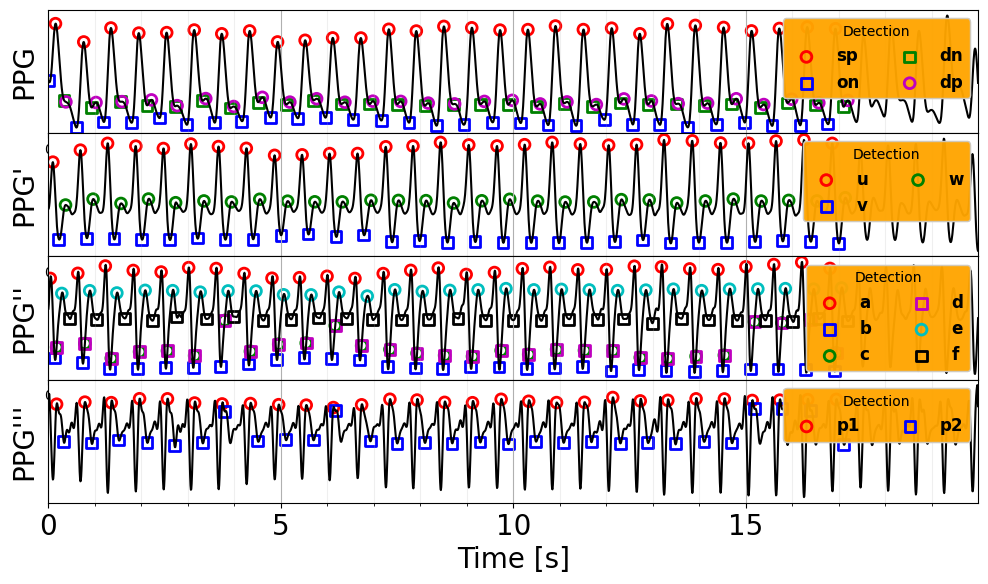

Figure has been saved in the "temp_dir".


In [13]:
# Create a fiducials class
fp = Fiducials(fiducials)

# Plot fiducial points
plot_fiducials(s, fp, savingfolder, legend_fontsize=12)

In [14]:
# Get PPG SQI
ppgSQI = round(np.mean(SQI.get_ppgSQI(s.ppg, s.fs, fp.sp)) * 100, 2)
print('Mean PPG SQI: ', ppgSQI, '%')

Mean PPG SQI:  99.26 %


Calculate PPG biomarkers:
_________________________

In [15]:
bmex = BM.BmCollection(s, fp)

In [16]:
bm_defs, bm_vals, bm_stats = bmex.get_biomarkers()
tmp_keys=bm_stats.keys()
print('Statistics of the biomarkers:')
for i in tmp_keys: print(i,'\n',bm_stats[i])

# Create a biomarkers class
bm = Biomarkers(bm_defs, bm_vals, bm_stats)

Statistics of the biomarkers:
ppg_sig 
                     Tpi       Tpp      Tsys      Tdia       Tsp       Tdp  \
Statistics                                                                  
mean           0.598571  0.599143  0.345714  0.183714  0.159143  0.414857   
median         0.600000  0.600000  0.344000  0.180000  0.160000  0.416000   
std            0.010913  0.006534  0.010110  0.013435  0.005792  0.016660   
percentile_25  0.592000  0.592000  0.336000  0.176000  0.158000  0.406000   
percentile_75  0.608000  0.602000  0.354000  0.192000  0.160000  0.424000   
iqr            0.016000  0.010000  0.018000  0.016000  0.002000  0.018000   
skew           0.155789 -0.194138  0.123521  1.051691 -0.399652 -0.426608   
kurtosis      -0.742472 -0.717518 -1.100450  0.890221  0.140338 -0.498165   
mad            0.008959  0.005163  0.008490  0.010571  0.004143  0.013878   

                 deltaT     Tsw10         Tsw25         Tsw33  ...  \
Statistics                                

Save PPG data:
______________

In [17]:
# Save PPG struct, fiducial points, biomarkers
fp_new = Fiducials(fp.get_fp() + s.start_sig) # here the starting sample is added so that the results are relative to the start of the original signal (rather than the start of the analysed segment)
save_data(s, fp_new, bm, savingformat, savingfolder)

Results have been saved into the "temp_dir".


In [18]:
# Calculate Inter-Beat Interval (IBI)
IBI = []
for i in range(28):
  IBI.append(fiducials.loc[i+1,'sp']-fiducials.loc[i,'sp'])
IBI

[76,
 73,
 75,
 75,
 74,
 74,
 75,
 75,
 74,
 74,
 76,
 75,
 74,
 74,
 75,
 76,
 75,
 74,
 75,
 76,
 76,
 74,
 75,
 76,
 75,
 75,
 75,
 76]

In [19]:
# Calculate Heart Rate for each IBI
Heart_Rates = [6000 / interval for interval in IBI]

print(Heart_Rates)
print(len(Heart_Rates))

[78.94736842105263, 82.1917808219178, 80.0, 80.0, 81.08108108108108, 81.08108108108108, 80.0, 80.0, 81.08108108108108, 81.08108108108108, 78.94736842105263, 80.0, 81.08108108108108, 81.08108108108108, 80.0, 78.94736842105263, 80.0, 81.08108108108108, 80.0, 78.94736842105263, 78.94736842105263, 81.08108108108108, 80.0, 78.94736842105263, 80.0, 80.0, 80.0, 78.94736842105263]
28


In [656]:
# Read specific columns from the CSV file for input data
columns = ['Tpi', 'Tsys','Tdia','Tsp', 'Tdp', 'deltaT', 'Tsw50','Tdw50','Tpw50']
file_path = '/content/temp_dir/Biomarker_vals/_ppg_sig_btwn_0-15001.csv'  # Ensure this is the correct path to your CSV file


In [657]:
# Read the CSV file
df = pd.read_csv(file_path, usecols=columns)

print(df)

      Tpi   Tsys   Tdia    Tsp    Tdp  deltaT  Tsw50  Tdw50  Tpw50
0   0.600  0.336  0.224  0.152  0.376   0.224  0.056  0.112  0.168
1   0.592  0.328  0.168  0.160  0.424   0.264  0.072  0.088  0.160
2   0.592  0.360  0.200  0.152  0.392   0.240  0.072  0.096  0.168
3   0.600  0.336  0.168  0.160  0.432   0.272  0.072  0.088  0.160
4   0.592  0.344  0.208  0.160  0.384   0.224  0.072  0.096  0.168
5   0.600  0.344  0.192  0.160  0.408   0.248  0.072  0.096  0.168
6   0.584  0.344  0.176  0.152  0.408   0.256  0.072  0.096  0.168
7   0.616  0.352  0.176  0.168  0.440   0.272  0.072  0.096  0.168
8   0.584  0.344  0.168  0.152  0.416   0.264  0.064  0.096  0.160
9   0.592  0.344  0.184  0.160  0.408   0.248  0.072  0.096  0.168
10  0.600  0.352  0.176  0.160  0.424   0.264  0.072  0.096  0.168
11  0.608  0.360  0.184  0.168  0.424   0.256  0.072  0.096  0.168
12  0.592  0.344  0.176  0.160  0.416   0.256  0.072  0.096  0.168
13  0.592  0.344  0.176  0.160  0.416   0.256  0.072  0.096  0

In [658]:
x = df
y= Heart_Rates
print(len(y))

28


Developing RF model

In [659]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [660]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

In [661]:
model = RandomForestRegressor()

In [662]:
model.fit(x_train,y_train)

RandomForestRegressor()

In [663]:
y_pred = model.predict(x_test)
y_pred

array([80.74679943, 79.8083322 , 80.38932949, 80.7596173 , 79.93598862,
       80.82219061])

In [664]:
mae = mean_absolute_error(y_test,y_pred)
mse = mean_squared_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)
print(f'Mean absolute error: {mae}')
print(f'Mean square error: {mse}')
print(f'R2_score: {r2}')

Mean absolute error: 0.4644459167170443
Mean square error: 0.29578902890053926
R2_score: 0.556203608819309
